# HOMER DATA PROCESSING SCRIPT
The goal of this script is to take the output file of HOMER Pro Batch Runs (.xlsx file containing one optimal case/sheet) and produce a condensed data set + plots.

General flow:
1) Run HOMER study via batch process. Select "export results" and name the file.


2) Import file to this script.


3) Use Pandas to pull .xlsx data into a more usable format. 


4) Use collected data to build plots. 

Goals:


Have this script take a large HOMER study (>100 cases) and build one easily accessible database.


Potentially couple this script with a HOMER input reading script to do cartography w/HOMER geography + results.


In [6]:
# Block of dependencies and working directory
import matplotlib.pyplot as plt
import conda
import numpy  as np 
import pandas as pd
import os 
import shutil
#directory = 'd:/repo/homer/ClimateStudies/OutputProcessing/Data' #home PC
#prod_dir = 'd:/repo/homer/ClimateStudies/ProductionCases/Case4/'
directory = 'c:/repo/homer/ClimateStudies/OutputProcessing/Data' #laptop
prod_dir  = 'c:/repo/homer/ClimateStudies/ProductionCases/Case4/'


## Following this guide for xlsx reading
https://stackoverflow.com/questions/26521266/using-pandas-to-pd-read-excel-for-multiple-worksheets-of-the-same-workbook

In [7]:
# reads, maps all sheets 
files = os.listdir(directory)
output_df = {} #creates empty dictionary
names = [] #creates empty list for future name storage
for file in files:
    if file.endswith('.xlsx'):
        xls = pd.ExcelFile(directory + '/' + file) #reads file
        names = names + xls.sheet_names
        for sheet_name in xls.sheet_names: #pulls individual sheets
            output_df[sheet_name] = xls.parse(sheet_name) #puts each sheet into a dictionary w/key "sheet_name"
#display(output_df[sheet_name])

In [8]:
#pulling interesting data points from each 
opt_out = pd.DataFrame(columns=['Architecture/PV\n(kW)', 'Architecture/G1500', 'Architecture/GenLarge\n(kW)', 'Architecture/1kWh LI',
                                                 'Cost/COE\n($)'])
n = len(names)
for i in range(n):
    name = names[i] # Grabs Sheet Name
    KCC = name[-3:]     #grabs KCC from last 3 values
    if KCC[-2:].casefold() == ('Af'.casefold()):
            KCC = 'Af'
            Location = name[5:-2]
            case_num = name[:5] # Grabs Case Number 
    elif KCC[-2:].casefold() == 'Am'.casefold():
            KCC = 'Am'
            Location = name[5:-2]
            case_num = name[:5] # Grabs Case Number 
    else: 
            Location = name[5:-3]
            case_num = name[:5] # Grabs Case Number 
    KCC = KCC.lower()

    #display(KCC[-2:])
    filtered_out = output_df[name].filter(['Architecture/PV\n(kW)', 'Architecture/G1500', 'Architecture/GenLarge\n(kW)', 'Architecture/1kWh LI',
                                                 'Cost/COE\n($)']) #Filtering objects of interest
    #display(filtered_out['Architecture/GenLarge\n(kW)'][2])
    if filtered_out['Architecture/GenLarge\n(kW)'][2] >= 2000:
        filtered_out['GenMin'] = 'False' #flags case for further cost increases
        if case_num == 'Case4':
            shutil.copyfile(prod_dir + name + '.homer', directory + '/NewCase/' + 'Case5' + name[5:] + '.homer')
    else: 
        filtered_out['GenMin'] = 'True' #nuclear cost is "maxed out"
    filtered_out['CaseName'] = Location #adding actual case name to series
    filtered_out['CaseNum'] = case_num # adding case num to series
    filtered_out['KCC'] = KCC
    framed = filtered_out.iloc[[0]] #making the actual df
    framed.set_index(['CaseNum','CaseName'], inplace=True, drop=True) #building df w/ casename and num
    opt_out = pd.concat([framed,opt_out]) #concating all DFs together
opt_out = opt_out[ ['KCC'] + [ col for col in opt_out.columns if col != 'KCC' ] ] #sorting df to have KCC first
opt_out = opt_out.sort_index()
opt_out.to_excel("LocationalVarianceTrimmed.xlsx")
#display(opt_out)
#display()

In [9]:
#for index = opt_out.ind
#display(pd.MultiIndex.get_level_values(opt_out('CaseNum')))
Case1 = opt_out.loc[("Case1",slice(None))]
Case2 = opt_out.loc[("Case2",slice(None))]
Case3 = opt_out.loc[("Case3",slice(None))]
Case4 = opt_out.loc[("Case4",slice(None))]
display(Case4)
#Case1.plot(y='Cost/COE\n($)', use_index=True)

,KCC,Architecture/PV\n(kW),Architecture/G1500,Architecture/GenLarge\n(kW),Architecture/1kWh LI,Cost/COE\n($),GenMin
CaseName,,,,,,,
AZYuma,bwh,18736.816329,2.0,3000.0,34227.0,0.159314,False
Anchorage,dfc,21000.218750,NaN,4000.0,27500.0,0.201563,False
Ashland,dfb,28906.246028,8.0,3000.0,29073,0.171841,False
AtlantaGA,cfa,15216.063618,3.0,4000.0,26305,0.189493,False
BangorME,dfb,13998.011895,5.0,4000.0,27146,0.193392,False
...,...,...,...,...,...,...,...
Syracuse,dfb,33010.742566,6.0,3000.0,32103,0.179424,False
TexasOil,bsh,14815.152633,6.0,2000.0,35220,0.131990,False
UPMich,dfb,17200.157069,9.0,3000.0,37649,0.162512,False


<Figure size 432x288 with 0 Axes>

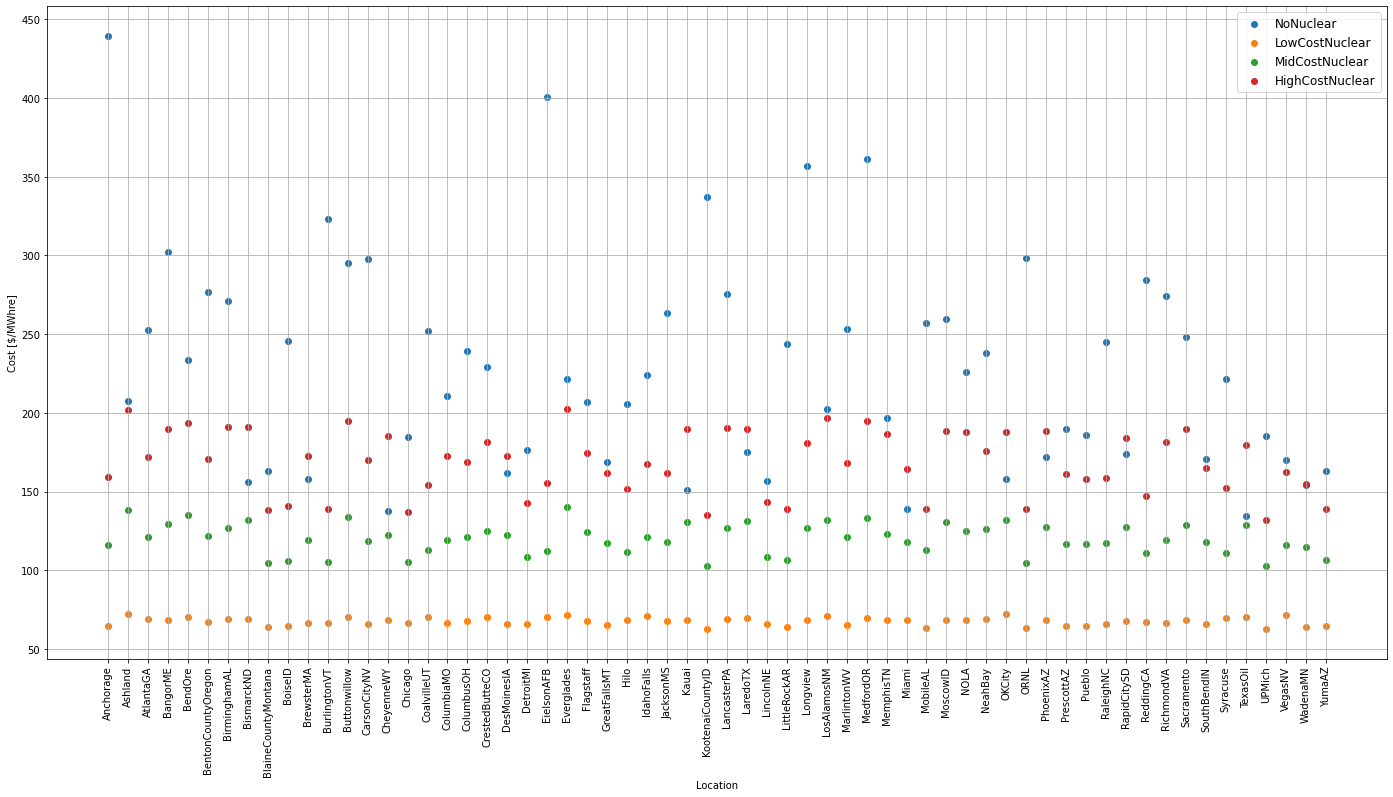

In [12]:
fig = plt.figure()
fig, ax=plt.subplots(figsize=(24,12))
ax.scatter(Case1.index.values,Case1['Cost/COE\n($)']*1000)
ax.scatter(Case1.index.values,Case2['Cost/COE\n($)']*1000)
ax.scatter(Case1.index.values,Case3['Cost/COE\n($)']*1000)
ax.scatter(Case1.index.values,Case4['Cost/COE\n($)']*1000)
ax.legend(['NoNuclear', 'LowCostNuclear', 'MidCostNuclear', 'HighCostNuclear'], fontsize='large')
plt.ylabel('Cost [\$/MWhre]')
plt.xlabel('Location')
plt.xticks(rotation=90);
ax.grid(True)
plt.savefig('LCOE.png',bbox_inches='tight')


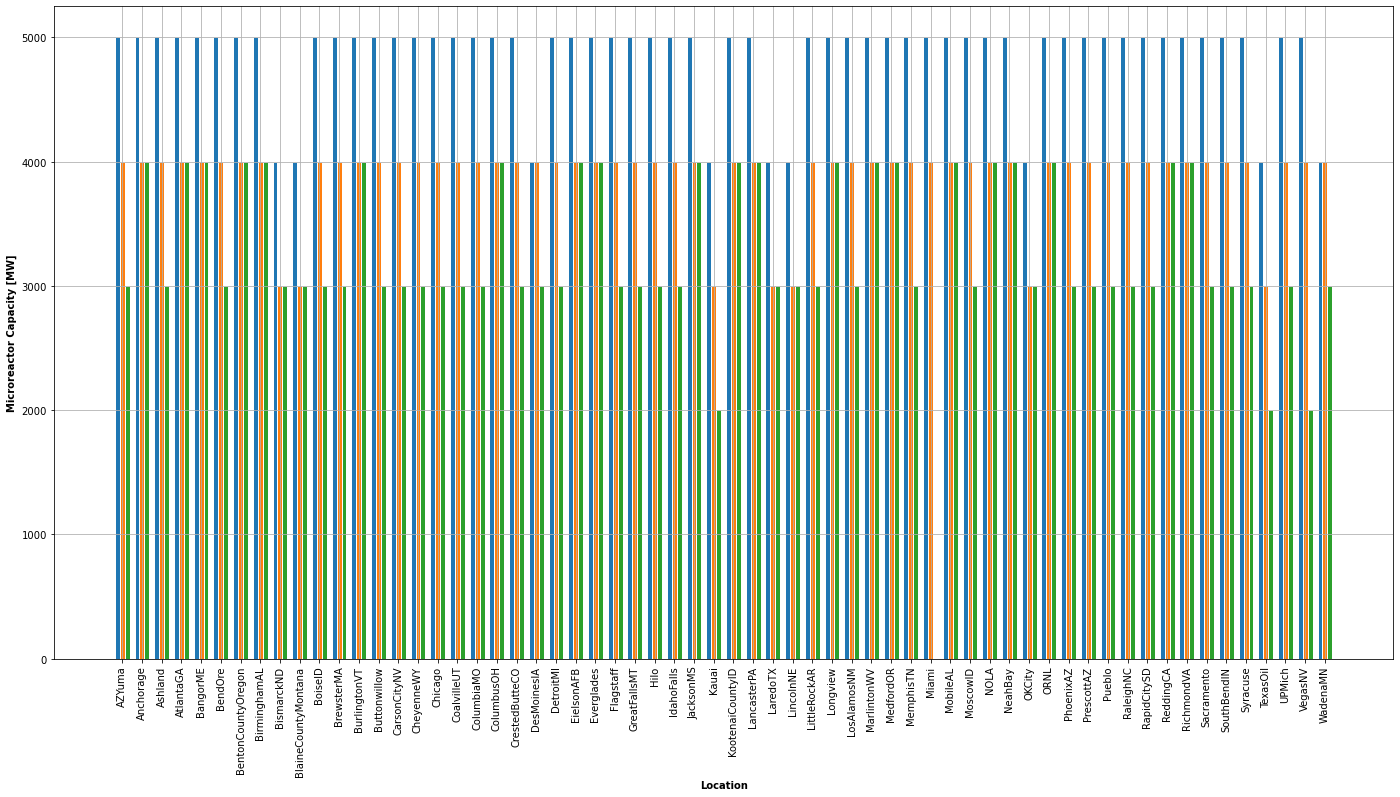

In [25]:
m = len(Case2)
fig = plt.figure(figsize=(24,12))
barWidth = 0.25
# Grabbing Generator Size Data
bars1 = Case2["Architecture/GenLarge\n(kW)"]
bars2 = Case3["Architecture/GenLarge\n(kW)"]
bars3 = Case4["Architecture/GenLarge\n(kW)"]
#ranges
r1 = np.arange(m)
r2 = [x+barWidth for x in r1]
r3 = [x+barWidth for x in r2]

# Plotting
plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='LowCostNuclear')
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='MidCostNuclear')
plt.bar(r3, bars3, width=barWidth, edgecolor='white', label='HighCostNuclear')
# Add xticks on the middle of the group bars
plt.xlabel('Location', fontweight='bold')
plt.ylabel('Microreactor Capacity [MW]', fontweight='bold')
plt.xticks([r + barWidth for r in range(m)], Case2.index.values)
plt.xticks(rotation=90);
plt.grid(True)
 


ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of ticklabels (62).

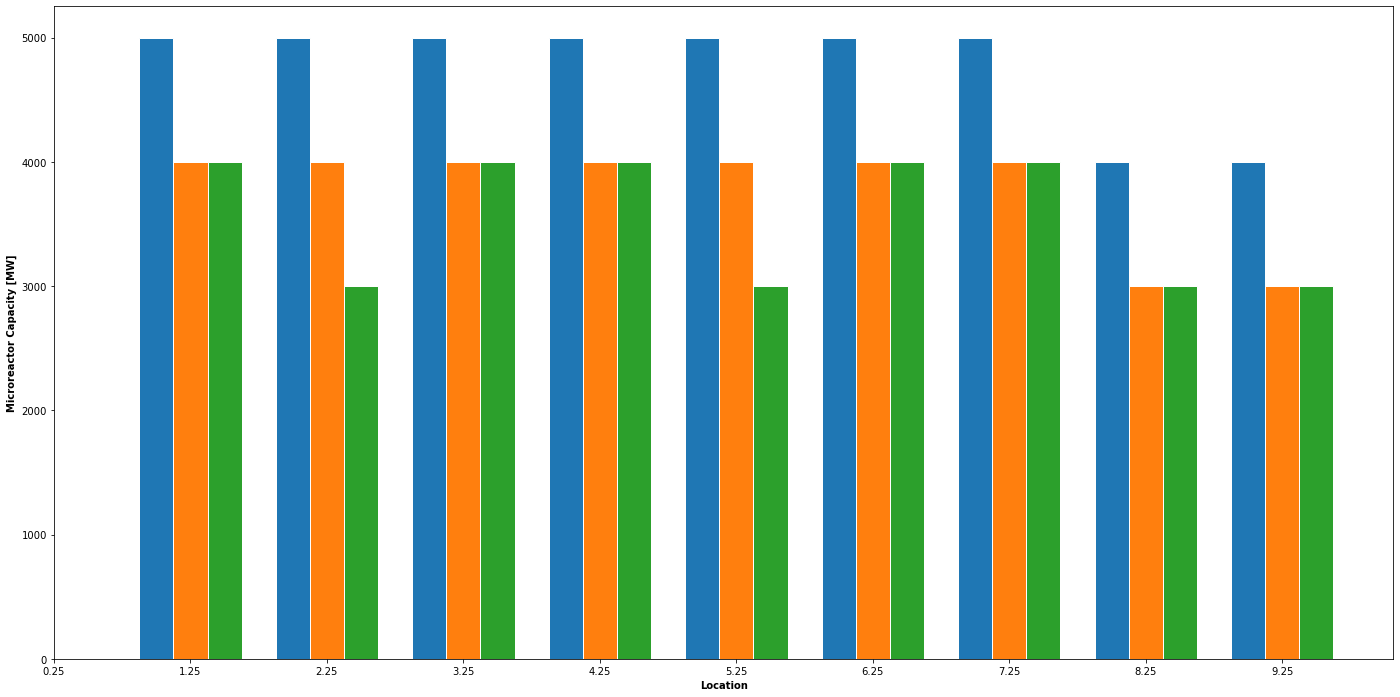

In [24]:
m = len(Case2)
fig = plt.figure(figsize=(24,12))
barWidth = 0.25
# Grabbing Generator Size Data
bars1 = Case2["Architecture/GenLarge\n(kW)"]
bars2 = Case3["Architecture/GenLarge\n(kW)"]
bars3 = Case4["Architecture/GenLarge\n(kW)"]
#ranges
r1 = np.arange(10)
r2 = [x+barWidth for x in r1]
r3 = [x+barWidth for x in r2]

# Plotting
plt.bar(r1[1:10], bars1[1:10], width=barWidth, edgecolor='white', label='LowCostNuclear')
plt.bar(r2[1:10], bars2[1:10], width=barWidth, edgecolor='white', label='MidCostNuclear')
plt.bar(r3[1:10], bars3[1:10], width=barWidth, edgecolor='white', label='HighCostNuclear')
# Add xticks on the middle of the group bars
plt.xlabel('Location', fontweight='bold')
plt.ylabel('Microreactor Capacity [MW]', fontweight='bold')
plt.xticks([r + barWidth for r in range(10)], Case2.index.values)
plt.xticks(rotation=90);
plt.grid(True)